# Claim management - Exploratory Analysis

## Importing libraries

In [1]:
# importing libraries.
import pandas as pd
import numpy as np
import random
from collections import Counter

# importing tools
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score

# importing models
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.lda import LDA
#from sklearn.qda import QDA

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Reading datasets (train and test) and looking at basic information

In [2]:
# Reading the train & test sets
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

In [3]:
# dimensions 
print df_train.shape, df_test.shape

# numbers of rows for train & test sets
num_rows_train = df_train.shape[0]
num_rows_test = df_test.shape[0]

# number of variables
num_variables = df_test.shape[1] - 1
print num_variables

(114321, 133) (114393, 132)
131


If we exclude ID and the target variable, there are 131 variables. As expected, the test set doesn't have the target variable.

In [4]:
# Check if ID has null and duplicates.
print df_train['ID'].isnull().sum(), \
    len(df_train['ID'].unique()) == df_train.shape[0]
print df_test['ID'].isnull().sum(), \
    len(df_test['ID'].unique()) == df_test.shape[0]

0 True
0 True


In [5]:
# Set ID as index
df_train.set_index('ID', inplace=True)
df_test.set_index('ID', inplace=True)

# Target is separated from df_train.
target_train = df_train.pop('target')

In [6]:
# column names
column_names = df_train.columns
print column_names

Index([u'v1', u'v2', u'v3', u'v4', u'v5', u'v6', u'v7', u'v8', u'v9', u'v10', 
       ...
       u'v122', u'v123', u'v124', u'v125', u'v126', u'v127', u'v128', u'v129',
       u'v130', u'v131'],
      dtype='object', length=131)


## Exploring category variables

In [7]:
# indices of category variables by looking at the data (23 out of 131)
category_variables = [2, 21, 23, 29, 30, 37, 46, 51, 55, 61,
                      65, 70, 71, 73, 74, 78, 90, 106, 109, 111,
                      112, 124, 128]
numerical_variables = [i for i in range(num_variables) if i not in category_variables]

for i in category_variables:
    print df_train.columns[i] + ":", df_train.iloc[:,i].nunique(), \
        np.sort(df_train.iloc[:,i].unique())
for i in category_variables:
    print df_test.columns[i] + ":", df_test.iloc[:,i].nunique(), \
        np.sort(df_test.iloc[:,i].unique())

v3: 3 [nan 'A' 'B' 'C']
v22: 18210 [nan 'AA' 'AAA' ..., 'ZZV' 'ZZW' 'ZZZ']
v24: 5 ['A' 'B' 'C' 'D' 'E']
v30: 7 [nan 'A' 'B' 'C' 'D' 'E' 'F' 'G']
v31: 3 [nan 'A' 'B' 'C']
v38: 12 [ 0  1  2  3  4  5  6  7  8  9 10 12]
v47: 10 ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
v52: 12 [nan 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L']
v56: 122 [nan 'A' 'AA' 'AB' 'AC' 'AE' 'AF' 'AG' 'AH' 'AI' 'AJ' 'AK' 'AL' 'AM' 'AN'
 'AO' 'AP' 'AR' 'AS' 'AT' 'AU' 'AV' 'AW' 'AX' 'AY' 'AZ' 'B' 'BA' 'BC' 'BD'
 'BE' 'BF' 'BG' 'BH' 'BI' 'BJ' 'BK' 'BL' 'BM' 'BN' 'BO' 'BP' 'BQ' 'BR' 'BS'
 'BT' 'BU' 'BV' 'BW' 'BX' 'BY' 'BZ' 'C' 'CA' 'CB' 'CC' 'CD' 'CE' 'CF' 'CG'
 'CH' 'CI' 'CJ' 'CK' 'CL' 'CM' 'CN' 'CO' 'CP' 'CQ' 'CS' 'CT' 'CV' 'CW' 'CX'
 'CY' 'CZ' 'D' 'DA' 'DB' 'DC' 'DD' 'DE' 'DF' 'DG' 'DH' 'DI' 'DJ' 'DK' 'DL'
 'DM' 'DN' 'DO' 'DP' 'DQ' 'DR' 'DS' 'DT' 'DU' 'DV' 'DW' 'DX' 'DY' 'DZ' 'E'
 'F' 'G' 'H' 'I' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
v62: 8 [0 1 2 3 4 5 6 7]
v66: 3 ['A' 'B' 'C']
v71: 9 ['A' 'B' '

Except the column 'v22' (18,211 values), all category variables have less than 100 values.

In [8]:
# Function to compare two lists (assumming both lists have unique values)
def list_compare(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return set1 == set2

In [9]:
# Checking if unique values are the same for category variables
for i in category_variables:
    print df_train.columns[i], list_compare(df_train.iloc[:,i].unique(), \
                       df_test.iloc[:,i].unique())

v3 True
v22 False
v24 True
v30 True
v31 True
v38 True
v47 False
v52 True
v56 False
v62 True
v66 True
v71 False
v72 True
v74 True
v75 True
v79 False
v91 True
v107 True
v110 True
v112 True
v113 False
v125 True
v129 True


6 variables have different values in train & test sets.

In [97]:
# Function to plot distributions of category variables (for train and test sets) 
#     and how much of each value has target 1 in the train set.
# data frames are assumed to be with independent variables and target is a separate series with 0 and 1.
# It also treats missing values as another value.
def plot_category_variables(df_train, df_test, target, category_variable_names):
    num_variables = len(category_variable_names)
    target_column_name = 'target'
    df_train_category = df_train[category_variable_names].copy()
    df_train_category = df_train_category.replace(np.nan, 'null')
    df_test_category = df_test[category_variable_names].copy()
    df_test_category = df_test_category.replace(np.nan, 'null')
    
    df_train_category[target_column_name] = target
    fig, axs = plt.subplots(3, len(category_variable_names), figsize=(13,10))
    for i, variable_name in enumerate(category_variable_names):
        counts_train = df_train_category.groupby(variable_name).size()
        counts_train.plot(kind='bar', ax=axs[0,i] if num_variables > 1 else axs[0], color='b', alpha=0.5)
        counts_test = df_test_category.groupby(variable_name).size()
        counts_test.plot(kind='bar', ax=axs[1,i] if num_variables > 1 else axs[1], color='g', alpha=0.5)
        ratios = df_train_category.groupby(variable_name)[target_column_name].mean()
        ratios.plot(kind='bar', ax=axs[2,i] if num_variables > 1 else axs[2], color='r', alpha =0.5)
        
    #plt.tight_layout()
    plt.suptitle('Total Counts and ratios of target 1')
    plt.show()

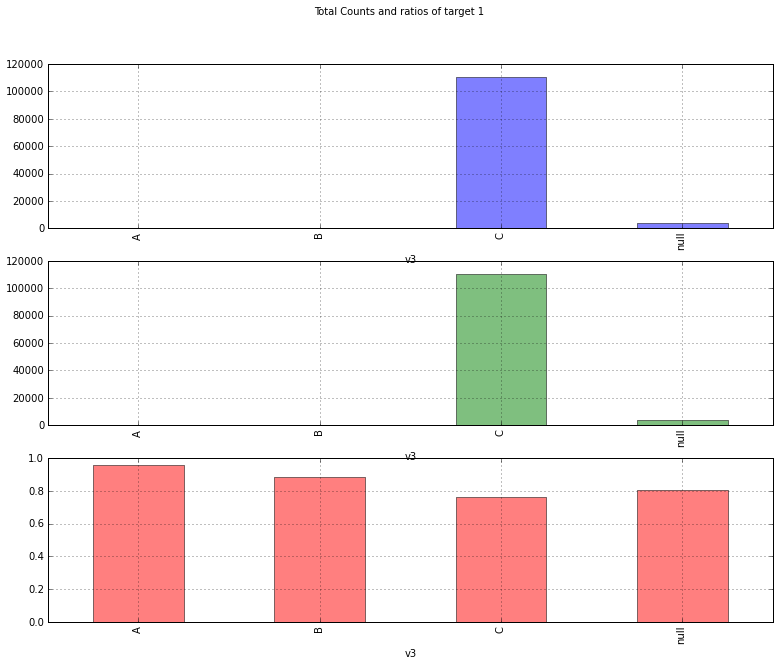

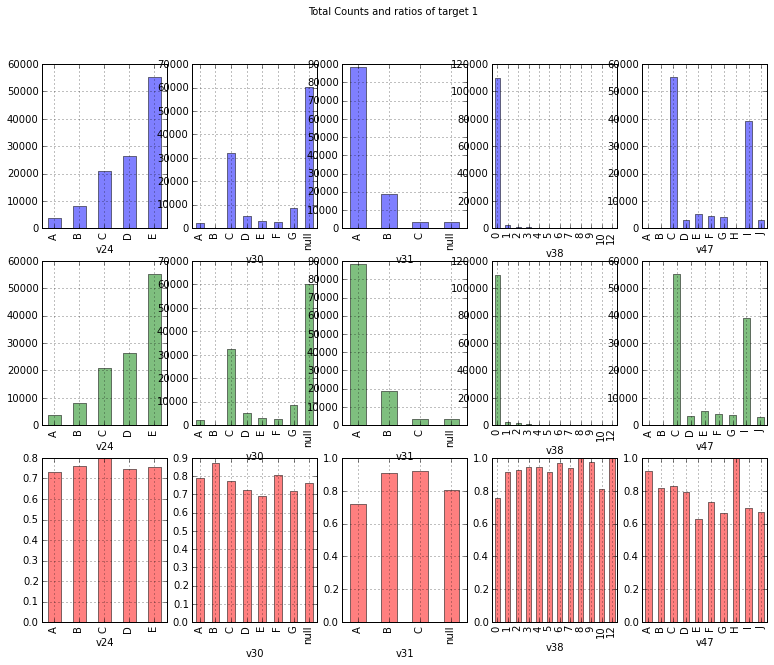

In [98]:
# Since 'v22' has too many values. We don't look at them in the plots.
plot_category_variables(df_train, df_test, target_train, [column_names[category_variables[0]]])

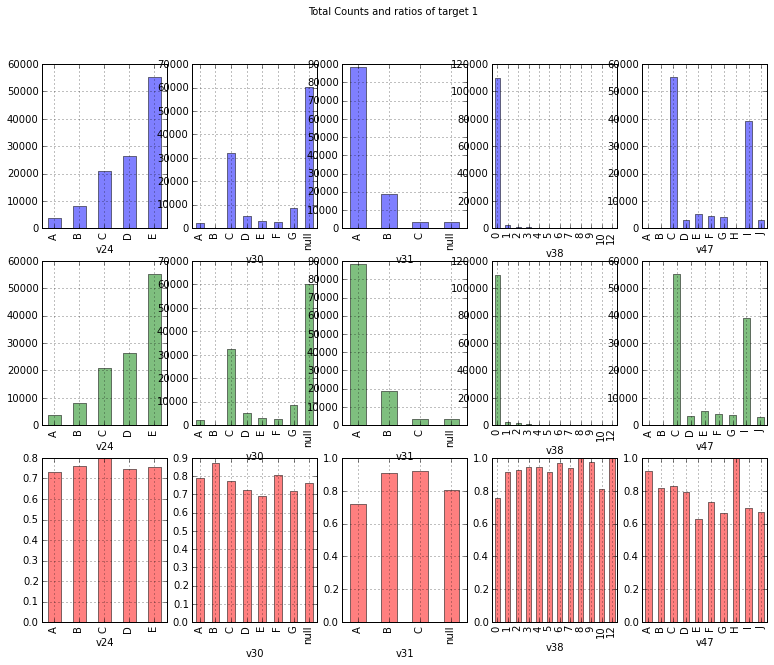

In [99]:
plot_category_variables(df_train, df_test, target_train, column_names[category_variables[2:7]])

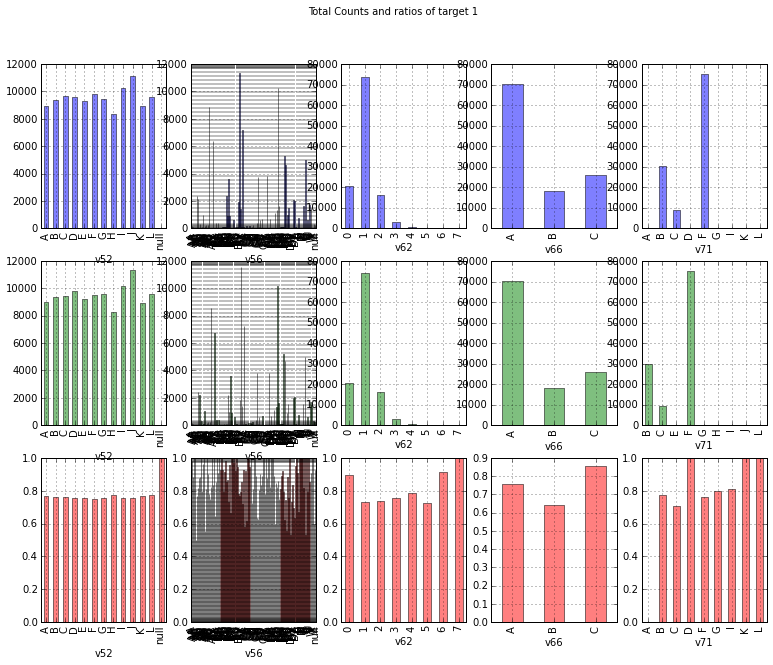

In [100]:
plot_category_variables(df_train, df_test, target_train, column_names[category_variables[7:12]])

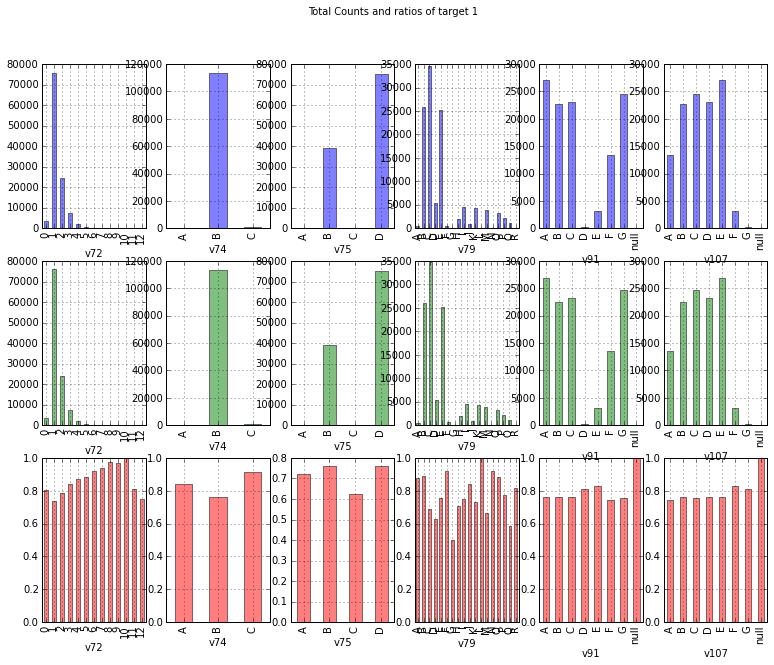

In [101]:
plot_category_variables(df_train, df_test, target_train, column_names[category_variables[12:18]])

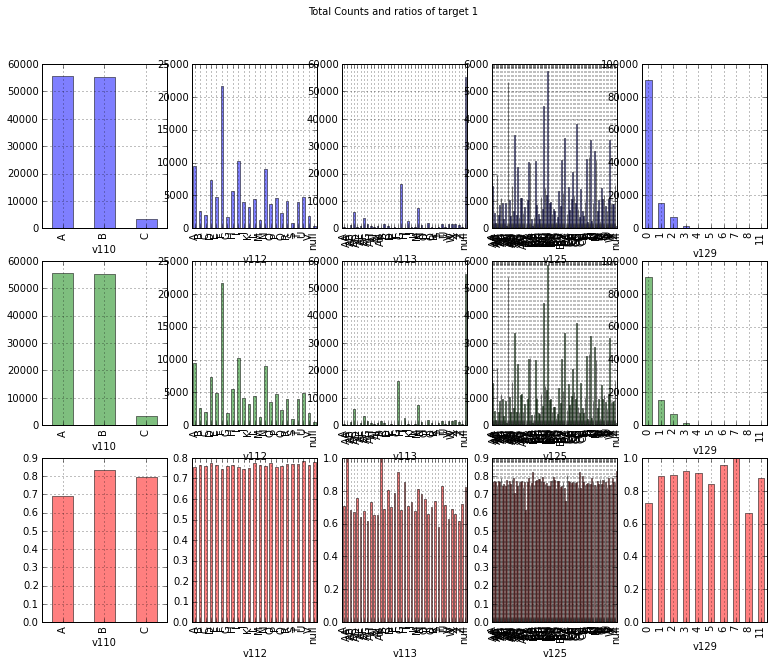

In [102]:
plot_category_variables(df_train, df_test, target_train, column_names[category_variables[18:24]])

## Missing values
### Based on rows

In [78]:
# The percentage of cells with nulls.
num_nulls_train = df_train.isnull()
num_nulls_by_row_train = num_nulls_train.sum(axis=1)
num_nulls_by_column_train = num_nulls_train.sum(axis=0)
print "For train set:", num_nulls_by_row_train.sum()/float(num_rows_train * num_variables)

num_nulls_test = df_test.isnull()
num_nulls_by_row_test = num_nulls_test.sum(axis=1)
num_nulls_by_column_test = num_nulls_test.sum(axis=0)
print "For test set:", num_nulls_by_row_test.sum()/float(num_rows_test * num_variables)

For train set: 0.340374842473
For test set: 0.34044554987


~ 1/3 of cells are nulls for both train & test sets

In [79]:
# percentage of rows with no null
print "For train set:", sum(num_nulls_by_row_train == 0)/float(num_rows_train)
print "For test set:", sum(num_nulls_by_row_test == 0)/float(num_rows_test)

For train set: 0.155317045862
For test set: 0.154301399561


Seems like only 15% of rows have no null value for both train & test sets. Now we will look into distributions of nulls in more detail.

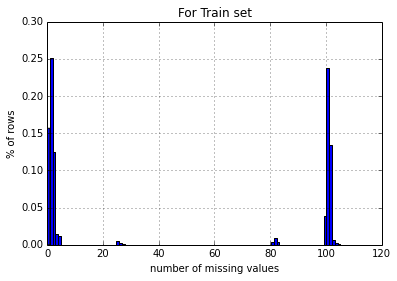

In [87]:
# The distribution of the number of null values for each row
num_nulls_by_row_train.hist(bins=119, normed=True)
plt.xlabel("number of missing values")
plt.ylabel("% of rows")
plt.title("For Train set")
plt.show()

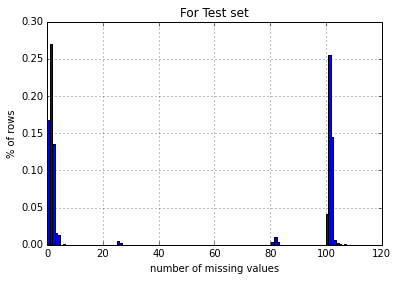

In [91]:
num_nulls_by_row_test.hist(bins=119, normed=True)
plt.xlabel("number of missing values")
plt.ylabel("% of rows")
plt.title("For Test set")
plt.show()

Above results show that there are some rows with more than 100 nulls out of 131 possible values. Strangely there is a peak near 100. Therefore we have to keep that in mind.  Also ~1/3 of possible values are missing. Based on these two facts, we need to find systematic ways to deal with missing data. 

In [16]:
# We need to more analysis on missing data.
# First, we will select rows with more than 80 nulls.
mask_null_80 = (num_nulls_by_row_train > 80)
print sum(mask_null_80), num_rows_train, \
    sum(mask_null_80)/float(num_rows_train)

 49796 114321 0.435580514516


~44% of rows have more than 80 nulls out of 131 values. If we divide the data into 2 groups based on the number of nulls (80 as the dividing point), you can compare the percentage of 1 for the target. 

In [18]:
# Percentage of target 1 out of rows with more than 80 rows.
print target_train[mask_null_80].sum()/float(sum(mask_null_80))
# Percentage of target 1 out of rows with less than 80 rows.
print target_train[~mask_null_80].sum()/float(sum(~mask_null_80))

0.770142180095
0.754296784192


They are not significantly different.
### Based on columns

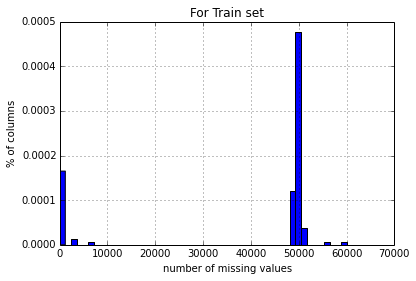

In [92]:
# We can plot distributions for columns, too.
num_nulls_by_column_train.hist(bins=50, normed=True)
plt.xlabel("number of missing values")
plt.ylabel("% of columns")
plt.title("For Train set")
plt.show()

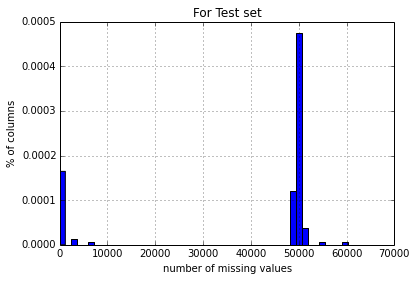

In [93]:
num_nulls_by_column_test.hist(bins=50, normed=True)
plt.xlabel("number of missing values")
plt.ylabel("% of columns")
plt.title("For Test set")
plt.show()

In [21]:
# percentages of nulls for only category varialbes
print df_train.iloc[:, category_variables].isnull().sum().sum() / \
    float(len(category_variables)*num_rows_train)
print df_test.iloc[:, category_variables].isnull().sum().sum() / \
    float(len(category_variables)*num_rows_test)

0.0495089532411
0.049631343359


Interesting to observe that there are not many nulls for category variables (5% compared to 34% overall). Therefore we will just assume null values as just another category. With above results, we can safely say that missing values are not randomly distributed. To observe that fact, we plot a scatter plot.

In [47]:
# Function to draw scatter plot of missing values based on their positions 
# in the data frame (x: column number, y: row number)
def draw_missing_values(df, num_rows=200, num_cols=200):
    num_rows = (df.shape[0] if df.shape[0] < num_rows else num_rows)
    num_cols = (df.shape[1] if df.shape[1] < num_cols else num_cols)
    chosen_rows = range(df.shape[0])
    random.shuffle(chosen_rows)
    chosen_rows = chosen_rows[:num_rows]
    df = df.iloc[chosen_rows, :num_cols] # columns are not picked randomly
    nulls = df.isnull()
    x = []
    y = []
    for i in range(num_rows):
        #if i % 100 == 0:
        #    print "progress:", i, "out of", num_rows
        for j in range(num_cols):
            if nulls.iloc[i,j]:
                x.append(j)
                y.append(num_rows - 1 - i)
    plt.scatter(x, y, color='blue', s=0.5, alpha=0.5)

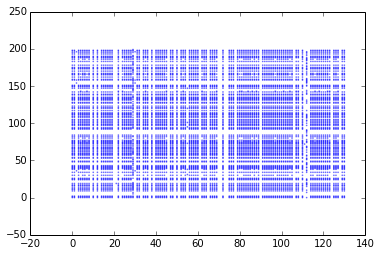

In [96]:
# draw patterns of missing values (200 rows will be chosen randomly)
draw_missing_values(df_train)

What we could see from this picture is that as expected there is a pattern (MNAR: Missing Not At Random). There are clearly two groups of rows as we have seen. For the group of rows with many missing values, the columns of missing values are almost the same. Vertical white strips mostly represent category variables as we have seen.

So it might be a good idea to divide the rows into two groups and to use different sets of columns (and different imputation methods) for predictions. Category variables have to be dealt differently.
### Only looking at category variables

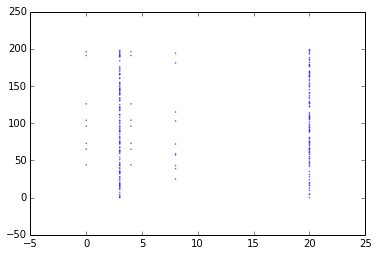

In [49]:
# Missing values for category variables only.
draw_missing_values(df_train[category_variables])

Two columns, 'v30' and 'v113', have many missing values.

In [67]:
# Find distributions of values for above two columns dependent on target
# values.
print Counter(df_train.ix[target_train==1, 'v30']).most_common()
print Counter(df_train.ix[target_train==0, 'v30']).most_common()

[(nan, 45881), ('C', 24921), ('G', 6298), ('D', 3772), ('F', 2088), ('E', 2051), ('A', 1831), ('B', 179)]
[(nan, 14229), ('C', 7257), ('G', 2430), ('D', 1453), ('E', 922), ('F', 501), ('A', 482), ('B', 26)]
